# 2.8 Multi-Agent 시스템과 RouteLLM

- 앞에서 개발한 `소득세 에이전트`와 `종합부동산세 에이전트`를 활용해서 다중 에이전트 시스템을 구현합니다

In [1]:
from dotenv import load_dotenv

load_dotenv()

True

In [2]:
from langchain_ollama import ChatOllama

llm_llama32v = ChatOllama(model="llama3.2-vision")
llm_qwen25c = ChatOllama(model="qwen2.5-coder:1.5b")

c:\Users\limjangmook\Desktop\ANSWER_25\inflearn-langgraph-agent\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from typing import TypedDict
from langgraph.graph import StateGraph

class AgentState(TypedDict):
    query: str
    context: list
    answer: str

workflow = StateGraph(AgentState)

In [4]:
from pydantic import BaseModel, Field
from typing import Literal
from langchain_core.prompts import ChatPromptTemplate

class Route(BaseModel):
    target: Literal["income_tax", "real_estate_tax", "llm"] = Field(
        description="The target for the query to answer")
structured_llm = llm_qwen25c.with_structured_output(schema=Route)

def router(state: AgentState) -> Literal["income_tax", "real_estate_tax", "llm"]:
    """
    사용자의 질문에 기반하여 적절한 경로를 결정합니다.
    Args:
        state (AgentState): 사용자의 질문을 포함한 에이전트의 현재 state.
    Returns:
        Literal["income_tax", "real_estate_tax", "llm"]: 질문을 처리하기 위한 적절한 경로를 나타내는 문자열.
    """
    print("router")

    query = state["query"]
    router_system_prompt = """
        사용자의 질문에 대해 "income_tax", "real_estate_tax", "llm" 셋 중 하나를 반환합니다.
        소득세 관련 정보가 포함되어 있으면 "income_tax"를 선택하고,
        종합부동산세 관련 정보가 포함되어 있으면 "real_estate_tax"를 선택하고,
        그 외 간단한 질문에 대해 답하려면 "llm"을 선택합니다. """
    router_prompt = ChatPromptTemplate.from_messages([
        ("system", router_system_prompt),
        ("human", "{query}")
    ])
    router_chain = router_prompt | structured_llm
    route = router_chain.invoke({"query": query})
    print(f"---> {route.target}")
    return route.target

In [5]:
def call_llm(state: AgentState) -> AgentState:
    """
    주어진 state에서 쿼리를 LLM에 전달하여 응답을 얻습니다.
    Args:
        state (AgentState): 현재 에이전트의 state를 나타내는 객체입니다.
    Returns:
        AgentState: 'answer' 키를 포함하는 새로운 state를 반환합니다.
    """
    print("call_llm")
    query = state["query"]
    response = llm_qwen25c.invoke(query)
    return {"answer": response.content}

- `node`를 추가하고 `edge`로 연결합니다
    - 앞에서 개발한 `agent`들을 `node`로 활용할 수 있습니다

In [6]:
from income_tax_graph_self_RAG import graph as income_tax_agent
from real_estate_tax_graph_parallel import graph as real_estate_tax_agent
from langgraph.graph import START, END

workflow.add_node("income_tax_agent", income_tax_agent)
workflow.add_node("real_estate_tax_agent", real_estate_tax_agent)
workflow.add_node("call_llm", call_llm)

workflow.add_conditional_edges(START, router, {
    "income_tax": "income_tax_agent",
    "real_estate_tax": "real_estate_tax_agent",
    "llm": "call_llm"
})
workflow.add_edge("income_tax_agent", END)
workflow.add_edge("real_estate_tax_agent", END)
workflow.add_edge("call_llm", END)

c:\Users\limjangmook\Desktop\ANSWER_25\inflearn-langgraph-agent\.venv\Lib\site-packages\langchain_tavily\tavily_research.py:97: UserWarning: Field name "output_schema" in "TavilyResearch" shadows an attribute in parent "BaseTool"
  class TavilyResearch(BaseTool):  # type: ignore[override, override]
c:\Users\limjangmook\Desktop\ANSWER_25\inflearn-langgraph-agent\.venv\Lib\site-packages\langchain_tavily\tavily_research.py:97: UserWarning: Field name "stream" in "TavilyResearch" shadows an attribute in parent "BaseTool"
  class TavilyResearch(BaseTool):  # type: ignore[override, override]


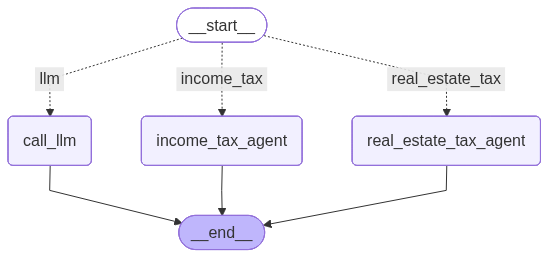

In [7]:
from IPython.display import display, Image

graph = workflow.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

In [8]:
question_1 = "소득세란 무엇인가요?"  # "income_tax"
response_1 = graph.invoke({"query": question_1})
response_1

router
---> income_tax
retrieve
is_doc_relevant
---> relevant
generate
is_hallucinated
---> non-hallucinated
check_helpfulness
is_helpful
---> helpful


{'query': '소득세란 무엇인가요?',
 'context': [Document(id='91ee9166-b245-457c-b866-6e9bfd6fb0b7', metadata={'source': './documents/income_tax_ocr.text'}, page_content='=== 페이지 1 시작 ===\n[일반 텍스트]\n법제처                                                            1                                                       국가법령정보센터\n소득세법\n \n소득세법\n[시행 2025. 1. 1.] [법률 제20615호, 2024. 12. 31., 일부개정]\n기획재정부 (재산세제과(양도소득세)) 044-215-4312\n기획재정부 (소득세제과(근로소득)) 044-215-4216\n기획재정부 (금융세제과(이자소득, 배당소득)) 044-215-4233\n기획재정부 (소득세제과(사업소득, 기타소득)) 044-215-4217\n       제1장 총칙 <개정 2009. 12. 31.>\n \n제1조(목적) 이 법은 개인의 소득에 대하여 소득의 성격과 납세자의 부담능력 등에 따라 적정하게 과세함으로써 조세부\n담의 형평을 도모하고 재정수입의 원활한 조달에 이바지함을 목적으로 한다.\n[본조신설 2009. 12. 31.]\n[종전 제1조는 제2조로 이동 <2009. 12. 31.>]\n \n제1조의2(정의) ① 이 법에서 사용하는 용어의 뜻은 다음과 같다. <개정 2010. 12. 27., 2014. 12. 23., 2018. 12. 31.>\n1. “거주자”란 국내에 주소를 두거나 183일 이상의 거소(居所)를 둔 개인을 말한다.\n2. “비거주자”란 거주자가 아닌 개인을 말한다.\n3. “내국법인”이란 「법인세법」 제2조제1호에 따른 내국법인을 말한다.\n4. “외국법인”이란 「법인세법」 제2조제3호에 따른 외국법인을 말한다.\n5. “사업자”란 

In [9]:
print(response_1["answer"].content)

소득세란 개인의 소득에 대하여 적정하게 과세함으로써 조세부담의 형평을 도모하고 재정수입의 원활한 조달에 이바지함을 목적으로 하는 세금입니다. 납세자는 거주자, 비거주자가 됩니다. 소득세의 과세기간은 1월 1일부터 12월 31일까지 1년으로 합니다.


In [15]:
question_2 = "15억짜리 집은 종합부동산세가 얼마인가요?"  # "real_estate_tax"
response_2 = graph.invoke({"query": question_2})
response_2

router
---> real_estate_tax
get_market_ratio
get_tax_base_equation
get_tax_deduction
calculate_tax_base
calculate_tax_rate


{'query': '15억짜리 집은 종합부동산세가 얼마인가요?'}

In [12]:
print(response_2["tax_rate"])  # answer

KeyError: 'tax_rate'

In [13]:
question_3 = "판교 대장동 오늘 날씨 알려줘"  # "llm"
response_3 = graph.invoke({"query": question_3})
response_3

router
---> llm
call_llm


{'query': '판교 대장동 오늘 날씨 알려줘',
 'answer': '죄송합니다, 현재 저는 실시간 데이터를 제공하는 서비스가 아니며, 판교대장동의 현재 날씨는 미국 시간에 대한 정보입니다. 이를 위해서는 외부 API나 웹사이트나 앱을 통해 확인해야 합니다.'}

In [14]:
print(response_3["answer"])

죄송합니다, 현재 저는 실시간 데이터를 제공하는 서비스가 아니며, 판교대장동의 현재 날씨는 미국 시간에 대한 정보입니다. 이를 위해서는 외부 API나 웹사이트나 앱을 통해 확인해야 합니다.
